# 🛠 08. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises
1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

## 1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.

* **Model 0:** Naive Bayers (baseline)
* **Model 1:** Feed-forward neural network (dense model)
* **Model 2:** LSTM model (RNN)
* **Model 3:** GRU Model (RNN)
* **Model 4:** Bidirectional-LSTM model (RNN)
* **Model 5:** 1D Convolutional Neural Network (CNN)
* **Model 6:** TensorFlow Hub Pretrained Feature Extractor ( using transfer learning for NLP)
* **Model 7:** Same as model 6 with 10% of data 


### Get the data

In [1]:
!rm -rf sample_submission.csv
!rm -rf test.csv
!rm -rf train.csv

!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
!unzip nlp_getting_started.zip
!rm -rf nlp_getting_started.zip

--2024-11-04 11:19:14--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.210.187, 216.58.211.251, 216.58.209.219, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.210.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.07s   

2024-11-04 11:19:14 (8.09 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]

Archive:  nlp_getting_started.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
import pandas as pd

In [3]:
train_df = pd.read_csv("train.csv")
train_df_shuffled = train_df.sample(frac=1, random_state=42)
from sklearn.model_selection import train_test_split
train_data, val_data, train_labels, val_labels = train_test_split(
    train_df_shuffled["text"].to_numpy(),
    train_df_shuffled["target"].to_numpy(),
    test_size=0.1, # use 10% of data for validation
    random_state=42
)

### Create vectorizer

In [4]:
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [5]:
max_vocab_length = 10000
max_length = 15

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    standardize='lower_and_strip_punctuation',
    split='whitespace',
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_length,
    pad_to_max_tokens=False,
)
text_vectorizer.adapt(train_data)

### Create embeddings

In [6]:
from tensorflow.keras import layers

In [7]:
embeddings = layers.Embedding(
    max_vocab_length,
    128,
    input_length=max_length
)

### Rebuild, compile and build `model_1`

In [8]:
model_1 = tf.keras.models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embeddings,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation="sigmoid")
])
model_1.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_1_history = model_1.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)
model_1_evaluation = model_1.evaluate(val_data, val_labels)

Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.6128 - accuracy: 0.6914 - val_loss: 0.5372 - val_accuracy: 0.7598
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.4413 - accuracy: 0.8196 - val_loss: 0.4734 - val_accuracy: 0.7835
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.3463 - accuracy: 0.8621 - val_loss: 0.4583 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.2842 - accuracy: 0.8913 - val_loss: 0.4646 - val_accuracy: 0.7874
Epoch 5/5
24/24 [==============================] - 0s 974us/step - loss: 0.4869 - accuracy: 0.7953


### Rebuild, compile and build `model_2`

In [9]:
model_2 = tf.keras.models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embeddings,
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")
])
model_2.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_2_history = model_2.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)
model_2_evaluation = model_2.evaluate(val_data, val_labels)

Epoch 1/5
215/215 [==============================] - 9s 31ms/step - loss: 0.2250 - accuracy: 0.9212 - val_loss: 0.5704 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1566 - accuracy: 0.9426 - val_loss: 0.6206 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1309 - accuracy: 0.9540 - val_loss: 0.7225 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.1045 - accuracy: 0.9600 - val_loss: 0.7883 - val_accuracy: 0.7795
Epoch 5/5
24/24 [==============================] - 0s 1ms/step - loss: 0.9178 - accuracy: 0.7782


### Rebuild, compile and build `model_5`

In [10]:
model_5 = tf.keras.models.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    text_vectorizer,
    embeddings,
    layers.Conv1D(64, 5, activation="relu", padding="valid"),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")
])
model_5.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_5_history = model_5.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)
model_5_evaluation = model_5.evaluate(val_data, val_labels)

Epoch 1/5
215/215 [==============================] - 7s 26ms/step - loss: 0.1518 - accuracy: 0.9463 - val_loss: 0.7677 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1005 - accuracy: 0.9619 - val_loss: 0.8661 - val_accuracy: 0.7795
Epoch 3/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0777 - accuracy: 0.9705 - val_loss: 0.9561 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 1s 3ms/step - loss: 0.0670 - accuracy: 0.9743 - val_loss: 0.9991 - val_accuracy: 0.7638
Epoch 5/5
24/24 [==============================] - 0s 1ms/step - loss: 1.1090 - accuracy: 0.7703


## 2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?

In [11]:
train_split = len(train_data) // 10
train_data_10_percent = train_data[:train_split]
train_labels_10_percent = train_labels[:train_split]

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

# Fit the pipeline to the traiing data
model_0.fit(train_data_10_percent, train_labels_10_percent)
model_0_evaluation = model_0.score(val_data, val_labels)
model_0_evaluation

0.7020997375328084

With less data Universal Sentence Encoder model works better

77.95% vs 70.20% accuracy

## 3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```

In [13]:
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True)
model_8 = tf.keras.models.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])
model_8.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4/2),
    metrics=["accuracy"]
)
model_8_history = model_8.fit(
    train_data,
    train_labels,
    epochs=10,
    validation_data=(val_data, val_labels)
)
model_8_evaluation = model_8.evaluate(val_data, val_labels)
model_8_evaluation

Epoch 1/10
215/215 [==============================] - 109s 382ms/step - loss: 0.6283 - accuracy: 0.6784 - val_loss: 0.5686 - val_accuracy: 0.7848
Epoch 2/10
215/215 [==============================] - 22s 103ms/step - loss: 0.5019 - accuracy: 0.8019 - val_loss: 0.4844 - val_accuracy: 0.8031
Epoch 3/10
215/215 [==============================] - 20s 92ms/step - loss: 0.4254 - accuracy: 0.8263 - val_loss: 0.4445 - val_accuracy: 0.8241
Epoch 4/10
215/215 [==============================] - 18s 83ms/step - loss: 0.3769 - accuracy: 0.8415 - val_loss: 0.4283 - val_accuracy: 0.8255
Epoch 5/10
215/215 [==============================] - 16s 76ms/step - loss: 0.3388 - accuracy: 0.8591 - val_loss: 0.4227 - val_accuracy: 0.8255
Epoch 6/10
215/215 [==============================] - 17s 79ms/step - loss: 0.2999 - accuracy: 0.8775 - val_loss: 0.4221 - val_accuracy: 0.8346
Epoch 7/10
215/215 [==============================] - 16s 74ms/step - loss: 0.2601 - accuracy: 0.8969 - val_loss: 0.4253 - val_accura

[0.47287407517433167, 0.8359580039978027]

| ------- | accuracy  | precision |  recall  |    f1    | 
| ------- | --------- | --------- | -------- | -------- |
| model_0 | 79.265092 | 0.811139  | 0.792651 | 0.786219 |
| model_1 | 77.821522 | 0.780165  | 0.778215 | 0.776141 |
| model_2 | 78.346457 | 0.783161  | 0.783465 | 0.783006 |
| model_3 | 77.559055 | 0.777207  | 0.775591 | 0.773618 |
| model_4 | 76.377953 | 0.764384  | 0.763780 | 0.762141 |
| model_5 | 74.803150 | 0.748333  | 0.748031 | 0.746284 |
| model_6 | 82.152231 | 0.823516  | 0.821522 | 0.820193 |
| model_7 | 77.952756 | 0.780242  | 0.779528 | 0.778108 |

## 4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?

In [14]:
train_data_all, train_labels_all = train_df_shuffled["text"].to_numpy(), train_df_shuffled["target"].to_numpy()

sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True)
tf.random.set_seed(42)
model_9 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6")

model_9.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=10**-4/2),
#    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

model_9_history = model_9.fit(
    train_data_all,
    train_labels_all,
    epochs=5
)

Epoch 1/5
238/238 [==============================] - 108s 347ms/step - loss: 0.6275 - accuracy: 0.6921
Epoch 2/5
238/238 [==============================] - 21s 87ms/step - loss: 0.4849 - accuracy: 0.8015
Epoch 3/5
238/238 [==============================] - 18s 77ms/step - loss: 0.4138 - accuracy: 0.8283
Epoch 4/5
238/238 [==============================] - 17s 72ms/step - loss: 0.3708 - accuracy: 0.8459
Epoch 5/5
238/238 [==============================] - 17s 71ms/step - loss: 0.3349 - accuracy: 0.8609


### Do the predictions

In [15]:
import pandas as pd

In [16]:
test_df = pd.read_csv("test.csv")
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [17]:
ids = test_df["id"]
texts = test_df["text"]
ids, texts

(0           0
 1           2
 2           3
 3           9
 4          11
         ...  
 3258    10861
 3259    10865
 3260    10868
 3261    10874
 3262    10875
 Name: id, Length: 3263, dtype: int64,
 0                      Just happened a terrible car crash
 1       Heard about #earthquake is different cities, s...
 2       there is a forest fire at spot pond, geese are...
 3                Apocalypse lighting. #Spokane #wildfires
 4           Typhoon Soudelor kills 28 in China and Taiwan
                               ...                        
 3258    EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
 3259    Storm in RI worse than last hurricane. My city...
 3260    Green Line derailment in Chicago http://t.co/U...
 3261    MEG issues Hazardous Weather Outlook (HWO) htt...
 3262    #CityofCalgary has activated its Municipal Eme...
 Name: text, Length: 3263, dtype: object)

In [30]:
model_9_preds = tf.cast(tf.squeeze(tf.round(model_9.predict(texts))), dtype=tf.int32)
model_9_df = pd.DataFrame({
    "id": ids,
    "target": model_9_preds
})
model_9_df

102/102 [==============================] - 0s 3ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [31]:
!rm submission.csv
model_9_df.to_csv("submission.csv", index=False)

## 5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?

### Create missing models

In [54]:
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeddings(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3")
model_3.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_3.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embeddings(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs)
model_4.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_4.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6")

model_6.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)
model_6.fit(
    train_data,
    train_labels,
    epochs=5,
    validation_data=(val_data, val_labels)
)

Epoch 1/5
215/215 [==============================] - 9s 29ms/step - loss: 0.1460 - accuracy: 0.9402 - val_loss: 0.7223 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0735 - accuracy: 0.9727 - val_loss: 0.8482 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.0624 - accuracy: 0.9762 - val_loss: 1.0866 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0589 - accuracy: 0.9777 - val_loss: 1.0599 - val_accuracy: 0.7690
Epoch 5/5
215/215 [==============================] - 1s 4ms/step - loss: 0.0476 - accuracy: 0.9785 - val_loss: 1.1426 - val_accuracy: 0.7677
Epoch 1/5
215/215 [==============================] - 11s 31ms/step - loss: 0.1013 - accuracy: 0.9711 - val_loss: 0.9907 - val_accuracy: 0.7664
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.0505 - accuracy: 0.9772 - val_loss: 1.2232 - val_accuracy: 0.7664
Epoch 3/5


In [55]:
# models 1, 2, 5, 8
model_1_preds = tf.squeeze(model_1.predict(val_data))
model_2_preds = tf.squeeze(model_2.predict(val_data))
model_3_preds = tf.squeeze(model_3.predict(val_data))
model_4_preds = tf.squeeze(model_4.predict(val_data))
model_5_preds = tf.squeeze(model_5.predict(val_data))
model_6_preds = tf.squeeze(model_6.predict(val_data))
model_8_preds = tf.squeeze(model_8.predict(val_data))
models_preds = tf.round((
    model_1_preds+
    model_2_preds+
    model_3_preds+
    model_4_preds+
    model_5_preds+
    model_6_preds+
    model_8_preds)/7)
models_preds_vote = tf.round((
    tf.round(model_1_preds)+
    tf.round(model_2_preds)+
    tf.round(model_3_preds)+
    tf.round(model_4_preds)+
    tf.round(model_5_preds)+
    tf.round(model_6_preds)+
    tf.round(model_8_preds))/7)


24/24 [==============================] - 0s 3ms/step


In [56]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred=val_labels):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1-score
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {
        "accuracy": model_accuracy,
        "precision": model_precision,
        "recall": model_recall,
        "f1": model_f1
    }
    return model_results

In [57]:
calculate_results(tf.round(model_1_preds)), calculate_results(tf.round(model_2_preds)), calculate_results(tf.round(model_5_preds)), calculate_results(tf.round(model_8_preds)), calculate_results(models_preds), calculate_results(models_preds_vote)

({'accuracy': 76.9028871391076,
  'precision': 0.7754311820467719,
  'recall': 0.7690288713910761,
  'f1': 0.7705161854768154},
 {'accuracy': 75.59055118110236,
  'precision': 0.7570761863162907,
  'recall': 0.7559055118110236,
  'f1': 0.7563031594734869},
 {'accuracy': 75.19685039370079,
  'precision': 0.753937281140707,
  'recall': 0.7519685039370079,
  'f1': 0.7525784723746596},
 {'accuracy': 83.59580052493439,
  'precision': 0.8386580987721363,
  'recall': 0.8359580052493438,
  'f1': 0.8365443165433805},
 {'accuracy': 77.42782152230971,
  'precision': 0.7779685179282625,
  'recall': 0.7742782152230971,
  'f1': 0.7752218457400435},
 {'accuracy': 76.50918635170603,
  'precision': 0.767752278716285,
  'recall': 0.7650918635170604,
  'f1': 0.7658407657817803})

## 6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

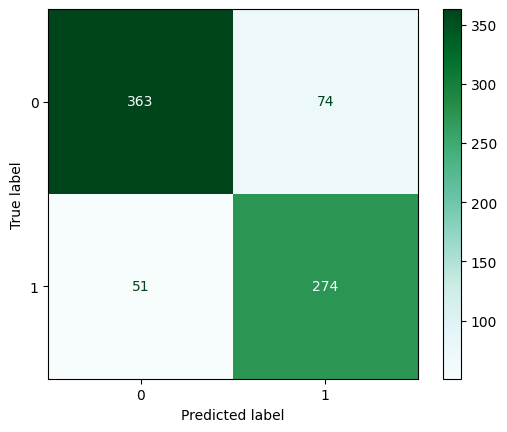

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(tf.round(model_8_preds), val_labels)).plot(cmap="BuGn")

In [67]:
!rm sample_submission.csv
!rm submission.csv
!rm test.csv
!rm train.csv